# NIFTY50 Stock Analysis (Version 0.4)

In [62]:
import numpy as np
import pandas as pd
from collections import Counter
import pandas_datareader as web
import datetime as dt

import bs4 as bs
import requests
import pickle  # coverts objects to bytestring and back.
import os

import matplotlib.pyplot as plt
from matplotlib import style
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates  # mpl doesn't use datetime dates 
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

#### For now, We'll import just 1 company for analysis 

We run the code cell below if company data is not already stored in local files.

In [143]:
# start = dt.datetime(2008, 1, 1)
# end = dt.datetime(2018, 12, 31) 

# df = web.DataReader('BPCL.NS', 'yahoo', start, end)
# df.to_csv("nifty50/companies/bpcl.csv")

In [5]:
df = pd.read_csv("nifty50/companies/bajaj_auto.csv", parse_dates=True, index_col=0)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,2476.399902,2432.000000,2457.000000,2451.750000,164726.0,2253.987793
2015-01-05,2481.199951,2450.000000,2452.000000,2460.699951,118873.0,2262.216309
2015-01-06,2469.899902,2430.000000,2454.300049,2441.500000,580496.0,2244.564941
2015-01-07,2475.600098,2432.050049,2442.000000,2447.199951,189191.0,2249.805176
2015-01-08,2465.000000,2436.100098,2447.649902,2450.399902,4301348.0,2252.746826


## Plotting Adj. Close prices against Date

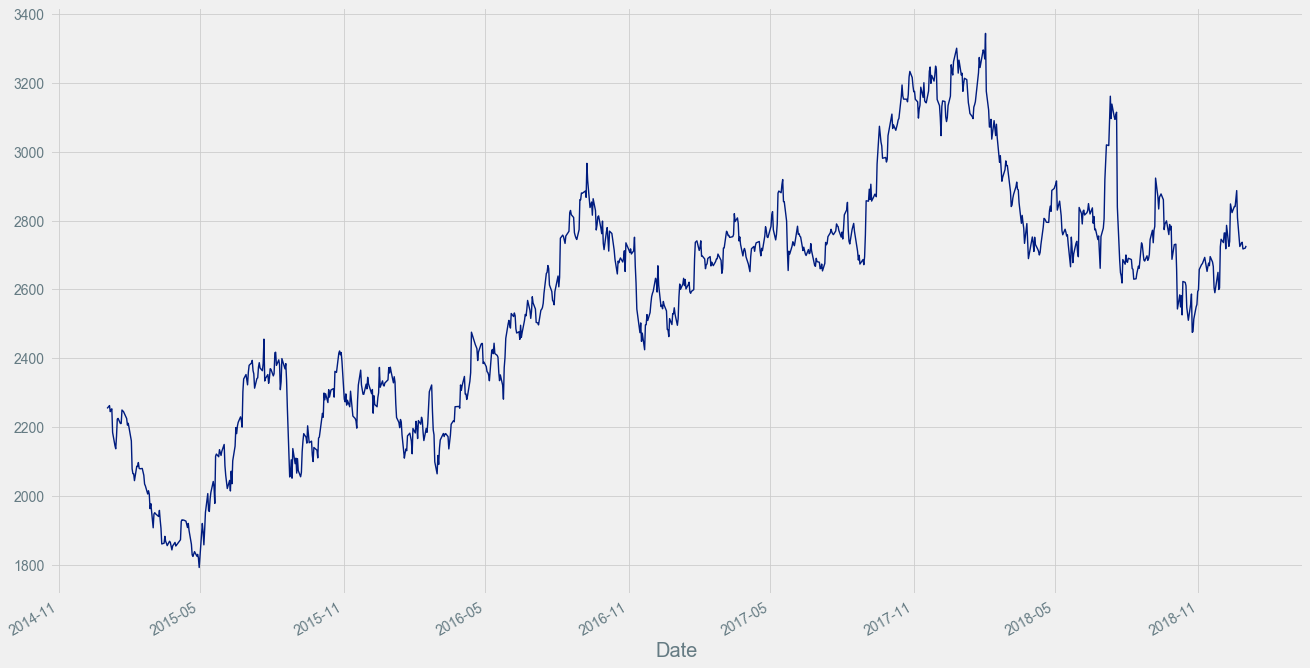

In [32]:
figure(1, figsize=(20, 12))

style.use(['fivethirtyeight', 'seaborn-dark-palette', 'seaborn-paper'])
ax = df['Adj Close'].plot(fontsize=14)
ax.set_xlabel('Date', fontsize=20)
plt.show()

## Plotting Moving averages (Lagging Indicators) 

In [28]:
# generating 100 day moving average 
df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()

# genreating 200 day moving average
df['200ma'] = df['Adj Close'].rolling(window=200, min_periods=0).mean()

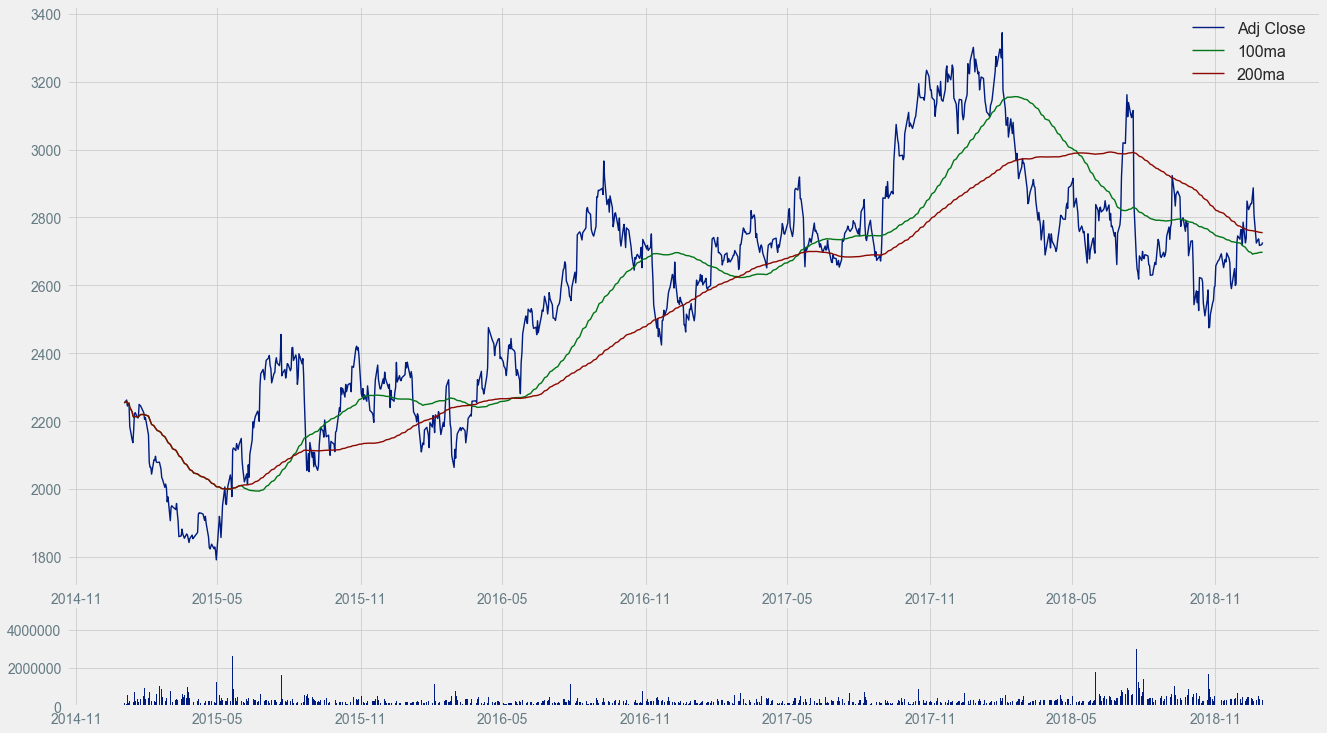

In [57]:
figure(2, figsize=(20, 12))

ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=4, colspan=1, sharex=ax1)

ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax1.plot(df.index, df['200ma'])
ax1.tick_params(axis = 'both', which = 'major', labelsize = 14)

ax2.bar(df.index, df['Volume'])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 14)

ax1.legend(prop={'size': 16})
plt.show()

print("Subplot 2 shows volume of stock traded on a particular day.")

## Getting candlestick plot (resampling data)

In [80]:
df_ohlc = df['Adj Close'].resample('5D').ohlc()
df_volume = df['Volume'].resample('5D').sum()

In [81]:
df_ohlc.reset_index(inplace=True)
df_ohlc.Date = df_ohlc.Date.map(mdates.date2num)  # converts datetime to matplot compliant dates (Unix Epoch)

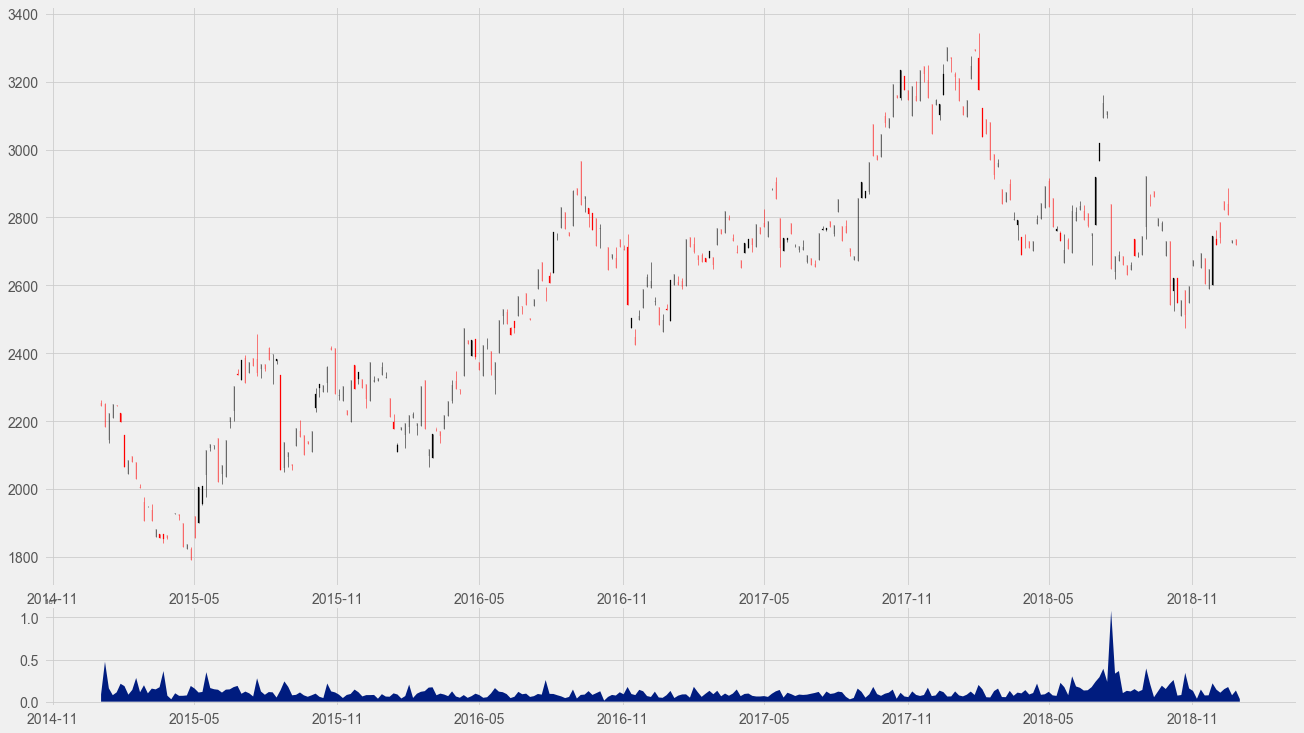

In [182]:
figure(3, figsize=(20, 12))
style.use(['fivethirtyeight', 'seaborn-dark-palette', 'seaborn-paper'])

ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=5, colspan=1, sharex=ax1)

ax1.xaxis_date()  # takes mdates and displays as normal dates
ax1.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 14)

candlestick_ohlc(ax1, df_ohlc.values, colorup='k')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)

## Scraping symbols for nifty 50 companies

Having the entire set of nifty50 company symbols will make help automating the data retrieval process

In [178]:
def save_symbols():
    
    symbols = list()
    response = requests.get('https://en.wikipedia.org/wiki/NIFTY_50').text
    soup = bs.BeautifulSoup(response, "lxml")
    
    table = soup.find('table', id='constituents')

    for row in table.find_all('tr')[1:]:
        data = row.find_all('td')[1].text
        symbols.append(data)
        
    if not os.path.exists("nifty50"):
        os.makedirs("nifty50")
        

    with open("nifty50/nifty50symbols.pickle", "wb") as f:
        pickle.dump(symbols, f)
        
    return symbols

## Function to Get/update all companies data

In [169]:
def get_data_from_yahoo():
    
    symbols = save_symbols()
    start = dt.datetime(2008, 1, 1)
    end = dt.datetime(2018, 12, 31)
    
    if not os.path.exists("nifty50/companies"):
        os.makedirs("nifty50/companies")
    
    for symb in symbols:

        ticker = symb.split('.')[0].lower().replace('-', '_')
        
        df = web.DataReader(symb, 'yahoo', start, end)
        df.to_csv(f"nifty50/companies/{ticker}.csv")
        print(symb)

## Functions to plot data for company input 

In [165]:
def make_ma_plot():
    
    # generating 100 day moving average 
    df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()

    # genreating 200 day moving average
    df['200ma'] = df['Adj Close'].rolling(window=200, min_periods=0).mean()
    
    figure(figsize=(20, 12))
    style.use(['fivethirtyeight', 'seaborn-dark-palette', 'seaborn-paper'])

    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=4, colspan=1, sharex=ax1)

    ax1.plot(df.index, df['Adj Close'])
    ax1.plot(df.index, df['100ma'])
    ax1.plot(df.index, df['200ma'])
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 14)

    ax2.bar(df.index, df['Volume'])
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 14)

    ax1.legend(prop={'size': 16})
    plt.show()

In [166]:
def make_candlestick_plot():
    
    df_ohlc = df['Adj Close'].resample('5D').ohlc()
    df_volume = df['Volume'].resample('5D').sum()
    
    df_ohlc.reset_index(inplace=True)
    df_ohlc.Date = df_ohlc.Date.map(mdates.date2num)  # converts datetime to matplot compliant dates (Unix Epoch)
    
    figure(3, figsize=(20, 12))
    style.use(['fivethirtyeight', 'seaborn-dark-palette', 'seaborn-paper'])

    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=5, colspan=1, sharex=ax1)

    ax1.xaxis_date()  # takes mdates and displays as normal dates
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 14)

    candlestick_ohlc(ax1, df_ohlc.values, colorup='g')
    ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)
    plt.show()

In [167]:
def show_plots(symbol, update_ticker=False):
    
    if update_ticker:
        get_data_from_yahoo()
    
    ticker = symbol.split('.')[0].lower().replace('-', '_')
    
    if not os.path.exists(f"nifty50/companies/{ticker}.csv"):
        print(f"Ticker {symbol} not in path 'nifty50/companies/' try setting update_ticker=True ")
        
    else:
        df = pd.read_csv(f"nifty50/companies/{ticker}.csv", parse_dates=True, index_col=0)
        make_ma_plot()
        make_candlestick_plot()

## Merge all companies data into one dataframe for comparing

In [236]:
def compile_data():

    with open("nifty50/nifty50symbols.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        ticker = ticker.split('.')[0].lower().replace('-', '_')
        df = pd.read_csv(f"nifty50/companies/{ticker}.csv")
        df.set_index('Date', inplace=True)

        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df = df[[ticker]]

        if main_df.empty:
            main_df = df.copy()
        else:
            main_df = main_df.join(df, how='outer')

        if count % 5 == 0:
            print(count)

    main_df.to_csv("nifty50/companies/nifty50_joined_closes.csv")

## Relation between companies

Finding the correlation between companies can be extremely useful for predicting movement in stock prices. Here, we are finding the correlation of percentage change in prices between all 50 companies. We can then use the correlation values as features for predicting stock prices.

In [260]:
def visualize_data():
    df = pd.read_csv("nifty50/companies/nifty50_joined_closes.csv")
    df_corr = df.apply(pd.to_numeric, errors='coerce').pct_change().corr() 
    
    '''
    In finance we calculate correlations between 
    stock returns and not stock prices,as returns tend 
    to follow normal distribution and prices don't. 
    Therefore we calculate the percentage change.
    '''
                                                                           
    data = df_corr.values
    fig = plt.figure(figsize=(26, 18))
    ax = fig.add_subplot(1, 1, 1)
    
    style.use(['fivethirtyeight', 'seaborn-dark-palette', 'seaborn-paper'])
    heatmap = ax.pcolor(data, cmap='RdYlGn')
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    col_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

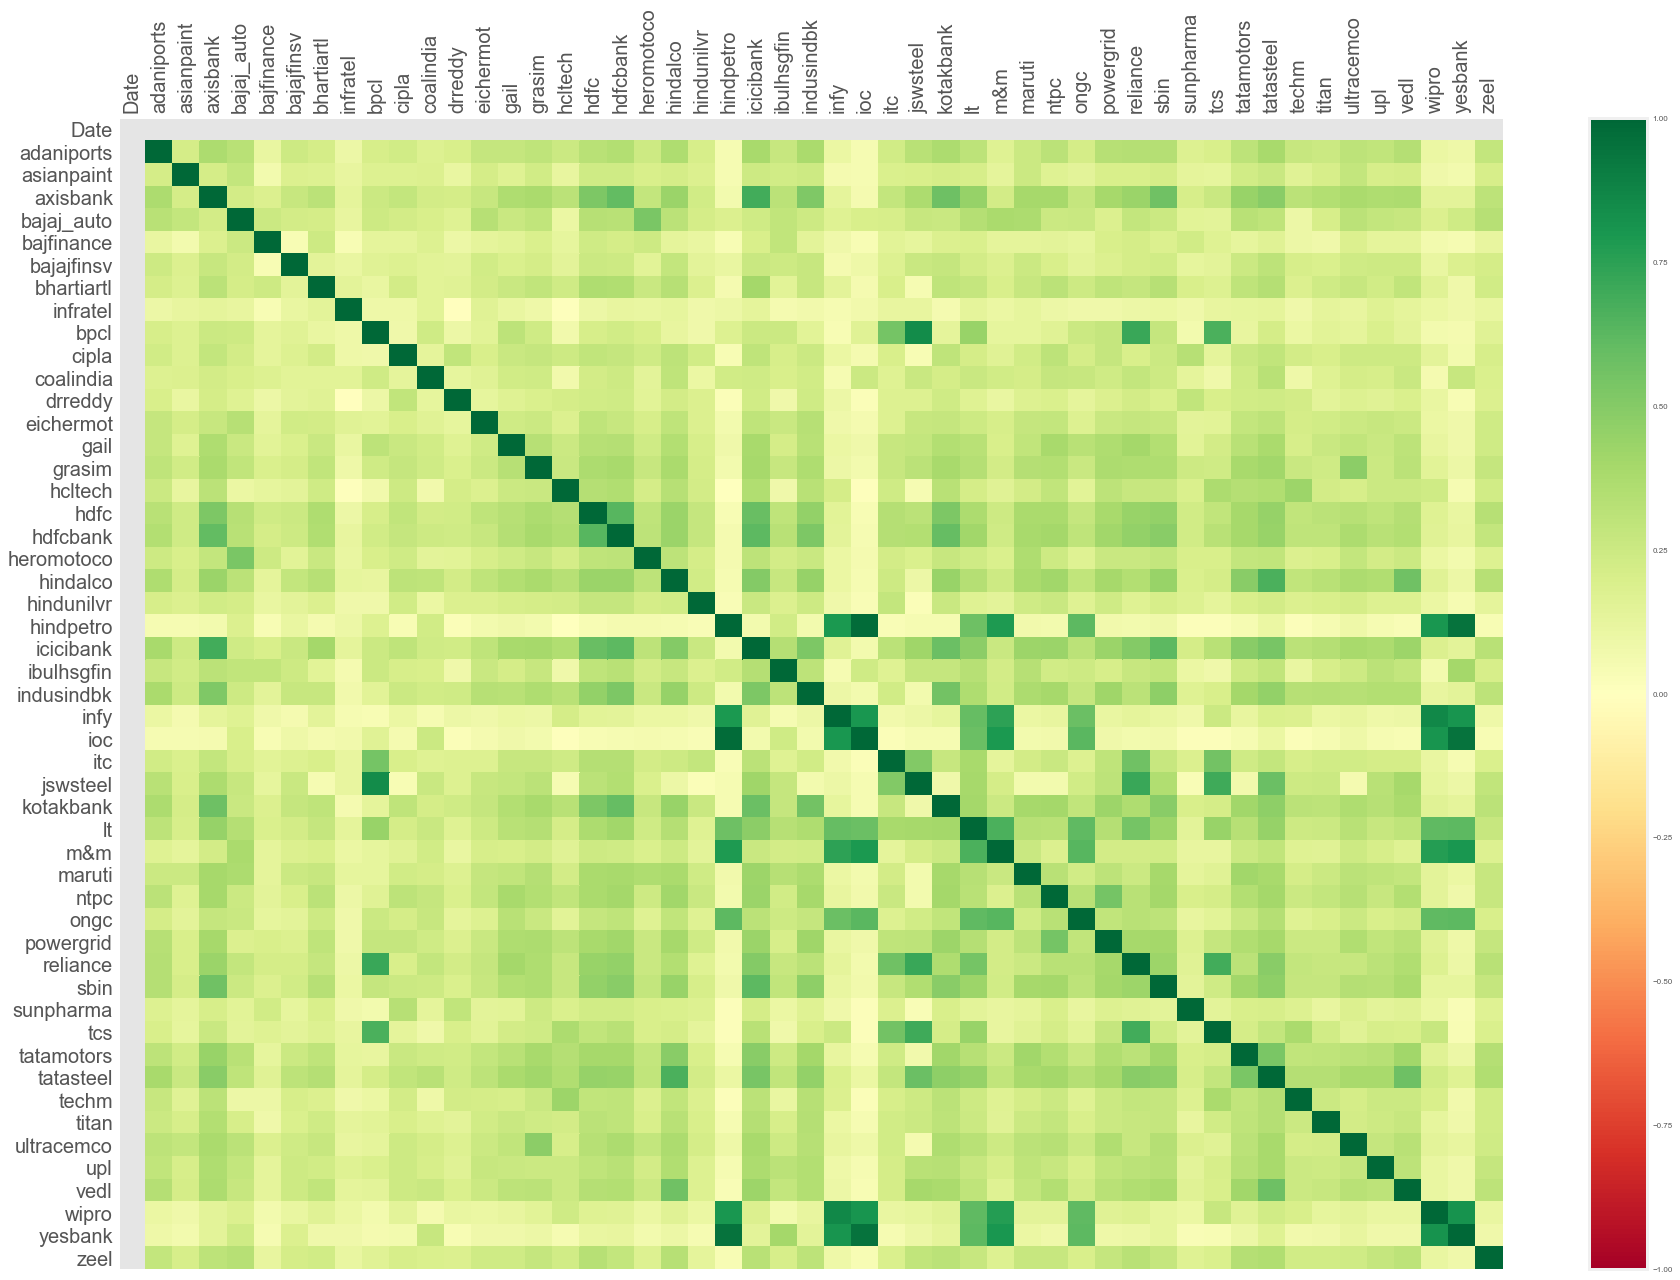

In [261]:
visualize_data()

## Predicting Buy Sell Hold

Here, percentage change for each of the last 'x' days is stored as a feature against every company. In this case we are calculating change for past 7 days. If stock price increases by more than two percent, we __BUY (return 1)__. If it decreases by more than two percent, we __SELL (return -1)__. Otherwise we __HOLD (return 0)__.

In [262]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv("nifty50/companies/nifty50_joined_closes.csv", index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)

    for i in range(1,hm_days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]

    df.fillna(0, inplace=True)
    return tickers, df

def buy_sell_hold(*args):
    '''if stock price increases by more than two percent BUY, if decreases by more than two percent SELL'''
    
    cols = [c for c in args]
    requirement = 0.02
    
    for col in cols:
        if col > requirement:
            return 1
        
        if col < -requirement:
            return -1
        
        return 0

In [263]:
def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)

    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)] ))
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:',Counter(str_vals))
    df.fillna(0, inplace=True)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values

    return X, y, df

## Choosing A Classifier

K-Nearest, Random Forest, and Support Vector Machine classifiers will use majority rulling to decide whether we should BUY, HOLD, SELL.

In [264]:
def do_ml(ticker):
    clf = VotingClassifier([('knn', KNeighborsClassifier()),
                            ('rfc', RandomForestClassifier()),
                            ('lsvc', svm.LinearSVC())])
    
    X, y, df = extract_featuresets(ticker)
    X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25)
    
    clf = clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    pred = clf.predict(X_train)
    print("predicted Spread:", Counter(pred))
    print(confidence)
    

In [266]:
do_ml('adaniports')

Data spread: Counter({'0': 1733, '1': 503, '-1': 473})


C:\Users\Aakash\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


predicted Spread: Counter({0: 1845, -1: 146, 1: 39})
0.6159527326440177
